# Lecture 3: Python for Scientific Computing (1.5 Hours) #

### ABSTRACT ###

In this Lecture, we will do yet another kind of stuff. **todo**

---

## Manipulating Arrays w/ NumPy and SciPy (40 Minutes) ##

So far, we've seen that Python offers flexible structures such as ``list`` and ``dict`` for storing data, but this flexibility comes at a cost. Consider, for instance, representing a matrix as a ``list`` of ``list`` instances.

In [116]:
x = [
    [0, 1],
    [1, 0]
]

In [117]:
x

[[0, 1], [1, 0]]

This "works" in the sense that it stores the data we're interested in, but fails to enforce that its entries are all numeric, that each "row" is the same length, and doesn't give us a terribly useful way of performing mathematical operations.

In [118]:
# Almost certainly not what we expect "matrix" addition to look like!
x + x

[[0, 1], [1, 0], [0, 1], [1, 0]]

In [119]:
# "Ragged" structures are OK for lists, even though that doesn't
# make sense for matrices.
x = [
    [0, 1, 0],
    [1, 0]
]
x

[[0, 1, 0], [1, 0]]

In [120]:
# Heterogeneuous data types are also OK for lists,
# but not what we want here.
x = [
    ["0", True],
    [1, None]
]
x

[['0', True], [1, None]]

None of this indicates that ``list`` is bad, but rather that it's not the data structure we want to represent tensors of numbers, such as vectors or matrices. Thankfully, the NumPy library provides precisely such a tensor structure, called an *array*. This library is installed by default with Anaconda, so let's go on and import it now.

In [121]:
import numpy as np
x = np.array([
    [0, 1],
    [1, 0]
])

In [122]:
x

array([[0, 1],
       [1, 0]])

In [123]:
x + x

array([[0, 2],
       [2, 0]])

In [124]:
2 * x

array([[0, 2],
       [2, 0]])

By contrast to ``list`` instances, arrays provide much more structure that we can use to represent numerical operations. The most basic operation allowed by arrays is that of *indexing*, wherein we access one or more elements of an array. This is similar to indexing lists, but much more powerful thanks to the additional assumptions that we can make about arrays. In particular, we can now index along multiple *dimensions* at once, each of which is also called an *axis* or an *index*.

In [125]:
x = np.array([
    [1, 2, 3],
    [4, 5, 6]
])
print(x[0, 1])

2


Each of these index expressions can itself be a slice, as we saw earlier with lists. The special slice ``:`` selects everything along that axis.

In [126]:
print(x[:, 0])
print(x[1, :])

[1 4]
[4 5 6]


In the example above, we note that indexing by a scalar removes that axis from the returned array, reducing the number of dimensions. This is represented in the array's *shape*, which describes the length of that array along each axis (this generalizes MATLAB's ``size`` concept to tensors of rank up to 63). Each shape is a ``tuple`` of integers, or the empty tuple for a scalar.

In [127]:
print(x.shape)
print(x[:, 0].shape)
print(x[1, :].shape)
print(x[1, :2].shape)
print(x[0, 0].shape)

(2L, 3L)
(2L,)
(3L,)
(2L,)
()


Each array also has a ``dtype``, short for "data type", indicating the type of each of its elements. This is in contrast to ``list`` instances, which can contain arbitrary other types, and allows arrays to be much more efficient.

In [128]:
print(x.dtype)
print(np.array([1.0]).dtype)
print(np.array([1j]).dtype)
print(np.array([True]).dtype)
print(np.array(["012"]).dtype)
# For something that's "just" an object that NumPy doesn't
# know how to handle, there's also an object dtype,
# but you lose most of the efficiency benefits.
print(np.array([object()]).dtype)
# Note that there's no efficient way to store dicts,
# so they get stored as objects!
print(np.array([{}]).dtype)

int32
float64
complex128
bool
|S3
object
object


NumPy provides the ``linspace`` function, similar to the similarly-named function in MATLAB, to quickly construct arrays of ``dtype`` ``float64`` with elements linearly spaced across an interval.

In [129]:
np.linspace(0, 1.1, 11)

array([ 0.  ,  0.11,  0.22,  0.33,  0.44,  0.55,  0.66,  0.77,  0.88,
        0.99,  1.1 ])

Arrays are also iterable, such that they can be used in ``for`` loops, ``map``, etc. There are often more powerful (and much faster!) ways of acting on arrays, as we'll see in a few minutes, but it's occasionally useful to iterate. When used in this way, an array iterates over its leftmost axis, yielding slices of the array. For example, if we think of a 2-axis array as a matrix whose first axis is a "row" and whose second index is a "column," then iterating yields row vectors as 1-axis arrays:

In [130]:
for vec in x:
    print(vec)

[1 2 3]
[4 5 6]


To iterate over an axis other than the leftmost, use the ``transpose`` method:

In [131]:
for col in x.transpose():
    print(col)

[1 4]
[2 5]
[3 6]


The ``transpose`` method is also exposed via the shorthand ``.T``:

In [132]:
np.all(x.transpose() == x.T)

True

In this example, if we did not call ``np.all``, we would get a Boolean array describing elementwise equality. For instance:

In [133]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[0, 2], [0, 0]])
print(a == b)

[[False  True]
 [False False]]


The ``np.all`` function then *reduces* an array by using a logical ``and``, returning ``True`` if and only if all elements of its argument are ``True``. We can also reduce only over a subset of axes, using the ``axis`` argument:

In [134]:
a = np.array([[1, 1], [0, 1]])
b = np.array([[1, 1], [-1, 1]])

print(np.all(a == b, axis=0))
print(np.all(a == b, axis=1))

[False  True]
[ True False]


This tells us that the first "rows" of ``a`` and ``b`` are equal, while the second ``columns`` of ``a`` and ``b`` are equal. Other useful reductions include ``np.max``, ``np.min``, ``np.median``, and ``np.mean``.

In [135]:
vec = np.array([-10, 0, 1])
for reduction_fn in (np.mean, np.median, np.min, np.max):
    print(reduction_fn, reduction_fn(vec))

(<function mean at 0x000000000487BC18>, -3.0)
(<function median at 0x0000000004989F98>, 0.0)
(<function amin at 0x000000000487B828>, -10)
(<function amax at 0x000000000487B7B8>, 1)


Of course, we will often want to actually perform arithmetic operations on arrays. In NumPy, such operations are represented by *universal functions*, or *ufuncs* for short. Each ufunc describes an element-wise operation which NumPy can then act on arrays.

In [136]:
a = np.array([[0, 1], [2, 3]])
b = np.array([[0, 10], [20, 30]])

In [137]:
a + b

array([[ 0, 11],
       [22, 33]])

In [138]:
a * b

array([[ 0, 10],
       [40, 90]])

In [139]:
b ** a

array([[    1,    10],
       [  400, 27000]])

In [140]:
-a

array([[ 0, -1],
       [-2, -3]])

Other useful ufuncs include trigionmetric functions, and special functions such as exp and log.

In [141]:
ys = np.array([1, 0, 1, 0])
xs = np.array([1, 1, 0, 0])

print(np.arctan2(ys, xs) / np.pi)
print(np.exp(xs + ys))

[ 0.25  0.    0.5   0.  ]
[ 7.3890561   2.71828183  2.71828183  1.        ]


A ufunc can be applied to two or more arrays if their shapes match exactly, or if one can be *broadcast* to each other. Before we explain what broadcasting is in detail, let's jump right into an example: adding a scalar to a 2-axis array:

In [142]:
a + 1

array([[1, 2],
       [3, 4]])

Here, we see that NumPy knew to "repeat" the scalar 1 such that it can then properly match the shape ``(2, 2)`` of ``a``. This holds even for higher-rank arrays. We can quickly make an example of a higher-rank array by using ``np.arange`` (short for "array range") to generate an array of integers equivalent to ``np.array(range(...))``, and then using ``reshape``. The ``reshape`` method returns the same array, but viewed as having a different shape, given by a tuple of the lengths along each axis of the new view.

In [143]:
a = np.arange(6)
a

array([0, 1, 2, 3, 4, 5])

In [144]:
b = a.reshape((2, 3, 1))
b

array([[[0],
        [1],
        [2]],

       [[3],
        [4],
        [5]]])

Note that because ``reshape`` returns a different view of the same array, modifying this view affects the original array and vice versa.

In [145]:
b[0, 0, 0] = 1000
a

array([1000,    1,    2,    3,    4,    5])

This behavior can be avoided by using the ``copy`` method. If we had used ``c = b`` then that would have just created a new name ``c`` that would point to the array ``b`` was also pointing too. 

In [146]:
c = b.copy()
c[0, 0, 0] = -1
a

array([1000,    1,    2,    3,    4,    5])

At any rate, returning to our earlier example, NumPy knows to "repeat" scalars even for higher-rank tensors.

In [147]:
a = np.arange(6).reshape((2, 3, 1))
a

array([[[0],
        [1],
        [2]],

       [[3],
        [4],
        [5]]])

In [148]:
a ** 2

array([[[ 0],
        [ 1],
        [ 4]],

       [[ 9],
        [16],
        [25]]])

Essentially, broadcasting consists of a formal list of rules for determining when and how to repeat lower-rank arrays to properly match shapes for elementwise computation. First, the arrays being operated on by a ufunc have different numbers of axes, singleton dimensions (axes of length 1) are added to the left of each array until they have the same length shapes.
For instance, if ``a`` is a ``(1, 2)``-shape array, and ``b`` is a ``(2,)``-shape array, then ``a`` and ``b`` are treated as having the same shape for the purpose of broadcasting.

Next, for each axis, the lengths along that axis must match for each array, or any non-matching arrays must have length 1. Thus, an array of shape ``(1, 2)`` and an array of shape ``(3, 1)`` can be broadcast with each other, but ``(2, 2)`` does not broadcast with ``(3, 1)``.

As a more applied example, we can use broadcasting together with ``np.newaxis`` to quickly define generalized outer products:

In [149]:
a = np.array([1, 2, 3])
b = np.array([4, 5])

print(a[:, np.newaxis] * b)
print(a[:, np.newaxis] + b)
print(a[:, np.newaxis] ** b)
print(a[:, np.newaxis] % b)

[[ 4  5]
 [ 8 10]
 [12 15]]
[[5 6]
 [6 7]
 [7 8]]
[[  1   1]
 [ 16  32]
 [ 81 243]]
[[1 1]
 [2 2]
 [3 3]]


This works because ``np.newaxis`` adds a new singleton axis at that location in the indexing operation. In the example above, ``a[:, np.newaxis]`` has shape ``(3, 1)``, which broadcasts with ``b`` (shape ``(2,)``) to return a shape ``(3, 2)`` array. Broadcasting thus gives us a very powerful tool for quickly performing index gymnastics, even on high-rank tensors.

In [150]:
a = np.arange(2 * 3 * 1).reshape((2, 3, 1))
b = np.arange(2 * 1 * 5).reshape((2, 1, 5))

print((a * b).shape)

(2L, 3L, 5L)


This covers elementwise multiplication, but what about matrix multiplication? Let's take a step back and first phrase matrix multiplication in a slightly different way. In particular, let $A_{ij}$ and $B_{k \ell}$ be matrices. Their product is then given by
$$
    (AB)_{ik} = \sum_j A_{ij} B_{jk}.
$$
Using Einstein summation convention, we can simplify this as $(AB)_{ik} = A_{ij} B_{jk}$, where the repeated index $j$ indicates a *tensor contraction*; that is, a sum over particular values of the repeated index.

This particular tensor contraction is implemented in NumPy as the function ``np.dot``. For arrays ``a`` and ``b``, ``np.dot(a, b)`` returns the tensor contraction of the last axis of ``a`` with the second-to-last axis of ``b``. For two-axis arrays, this is identical to matrix multiplication.

In [151]:
a = np.array([[0, 1], [1, 0]])
b = np.array([[0, -1j], [1j, 0]])

print(np.dot(a, b))

[[ 0.+1.j  0.+0.j]
 [ 0.+0.j  0.-1.j]]


If we are interested in multiplying several matrices together, this can get a bit ugly, with expressions like ``np.dot(a, np.dot(b, c))`` instead of ``A * B * C``. To help with this, we can use ``functools.reduce`` to simplify notation a bit:

In [152]:
from functools import reduce
a, b, c = np.arange(3 * 2 * 2).reshape((3, 2, 2))
reduce(np.dot, (a, b, c))

array([[118, 131],
       [518, 575]])

This reduction is done automatically by the ``np.linalg.multi_dot`` function, which chooses an efficient order to perform the tensor contractions:

In [153]:
np.linalg.multi_dot([a, b, c])

array([[118, 131],
       [518, 575]])

The optimization performed by ``multi_dot`` is especially helpful for larger matrices.

In [154]:
big_dimension = 131
small_dimension = 2

a = np.arange(big_dimension * small_dimension).reshape((big_dimension, small_dimension))
b = np.arange(small_dimension * big_dimension).reshape((small_dimension, big_dimension))
c = np.arange(big_dimension * big_dimension).reshape((big_dimension, big_dimension))
%timeit reduce(np.dot, (a, b, c))
%timeit np.linalg.multi_dot([a, b, c])

100 loops, best of 3: 4.25 ms per loop
1000 loops, best of 3: 222 µs per loop


<em>NB: Python 3.5 also adds the `@*` operator for matrix multiplication, but using this operator prevents 2.7 or 3.4 users from running your code.</em>

More generally, NumPy offers the ``np.tensordot`` function for computing arbitrary tensor contractions. For arrays ``a`` and ``b`` and an integer ``k``, ``np.tensordot(a, b, k)`` contracts the ``k`` rightmost axes of ``a`` with the ``k`` leftmost axes of ``b``. Alternatively, the third argument of ``np.tensordot`` can be a tuple of two lists, specifying corresponding axes of ``a`` and ``b`` to contract over.

In [155]:
a = np.arange(2 * 3 * 5 * 7).reshape((2, 3, 5, 7))
b = np.arange(5 * 11 * 7 * 13).reshape((5, 11, 7, 13))

print(np.tensordot(a, b, ([2, 3], [0, 2])).shape)

(2L, 3L, 11L, 13L)


Put differently, we can think of NumPy as an efficient library for manipulating and contracting high-rank tensors. Of course, we will often be interested in the special case of rank-2 tensors (matrices); NumPy is helpful in this special case as well.

In [156]:
eigenvalues, eigenvectors = np.linalg.eig([[0, 1], [1, 0]])

## Pandas (15 Minutes) ##

**todo**: dbl check that pandas is installed.

In addition to NumPy's representation of tensors, we can use the Pandas library to manage data in an R- or Excel-like fashion with the ``DataFrame`` class. Pandas is extremely powerful, and we'll barely scratch the surface here. That note aside, let's jump in by importing Pandas and making our first ``DataFrame``. Since apparently patents are important, we'll use as an example data set the [number of patents filed in Melbourne](https://data.melbourne.vic.gov.au/Economy/Standard-And-Innovation-Patents-by-Postcode-In-Mel/9usq-v437) as a function of year and, er, postal code.

In [1]:
import pandas as pd

In [5]:
pd.read_csv("https://data.melbourne.vic.gov.au/api/views/9usq-v437/rows.csv?accessType=DOWNLOAD", index_col='Postcode')

,2010,2011,2012,2013,2014
Postcode,,,,,
3000,55,72,86,56,54
3001,0,0,0,0,3
3002,1,1,4,1,1
3003,0,2,3,2,1
3004,4,10,7,12,9
3005,0,1,0,0,0
3006,3,13,5,7,7
3010,3,6,1,5,5
3031,0,0,1,2,0


**todo** explain why ``index_col``, pick up from here.

- Loading data into data frames (NumPy arrays, CSV, Excel)
- Groupby / pivot, etc.
- Reductions

## Plotting with Matplotlib and Seaborn (35 Minutes) ##

We can make plots uing the Matplotlib library for Python, so let's jump right in by importing that now.

In [157]:
import matplotlib.pyplot as plt

Note that we've only imported ``pyplot`` from Matplotlib; this is the MATLAB-like interface for Matplotlib. As usual, we've given the package a short name (``plt``) to make it easier to refer to Matplotlib functions. Having imported Matplotlib, we now tell Jupyter Notebook to place plots into the notebook itself, rather than displaying them in a separate window.

In [158]:
%matplotlib inline

We're now ready to plot things. The first plotting function that we'll consider is given the thankfully unimaginative name of ``plot``.

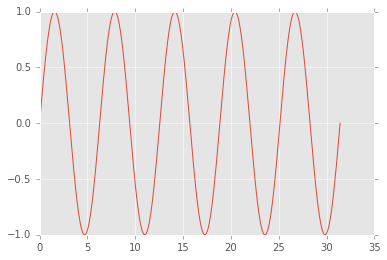

In [159]:
xs = np.linspace(0, 10 * np.pi, 401)
plt.plot(xs, np.sin(xs))

We can decorate our plot and its axes using functions like ``xlabel`` and ``title``. In calling these functions, mathematical expressions between \$ signs is typeset as LaTeX. Since LaTeX uses a lot of backslashes, which indicate special characters in Python, we can use *raw string* notation to help. When a string literal is prefaced by ``r``, backslashes inside that string do not indicate special characters. For instance, ``"\n"`` is a newline, but ``r"\n"`` is a two-character string containing a backslash and the letter "n."

*NB: when using ``%matplotlib inline``, we can't modify figures after their cell has completed. Thus, we'll first make a function for our figure then call it to avoid repetition.*

In [160]:
def sinusoid_figure():
    xs = np.linspace(0, 10 * np.pi, 401)

    plt.plot(xs, np.sin(xs))
    
    # xlabel and ylabel do what they say on the tin, namely
    # labelling the x and y axes.
    plt.xlabel('$x$')
    plt.ylabel(r'$\sin(x)$')
    
    # xticks lets us set where tick marks are placed,
    # and what they should be labeled as.
    plt.xticks(
        np.arange(11) * (np.pi),
        ['0'] + [r'${} \pi$'.format(k) for k in range(1, 11)]
    )
    
    # xlim and ylim let us control the limits of plots.
    plt.xlim(0, 10 * np.pi)
    plt.ylim(-1.01, 1.01)

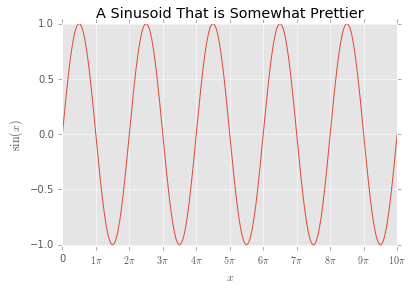

In [161]:
sinusoid_figure()
plt.title('A Sinusoid That is Somewhat Prettier')

As the title says, though, this figure still looks awfully, well, plain. We can use Matplotlib's stylesheets to make our figures a bit nicer looking. Below, we repeat the sinusoid plot for each different stylesheet. You may have other styles available, depending on what packages you have installed.

To temporarily apply a style for one figure, we'll use the ``plt.style.context`` function. This function is a *context manager*, which means that we can use it with the **`with`** keyword. This ensures that no matter what happens in the ``with`` block, the context manager will get a chance to clean up after itself. Matplotlib defines the cleanup for ``context`` to restore whatever style we had before, such that it's very easy to use a style for only one figure.

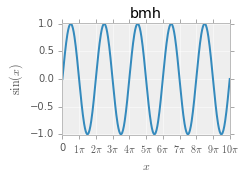

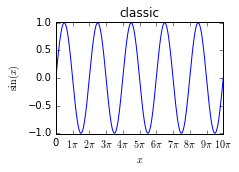

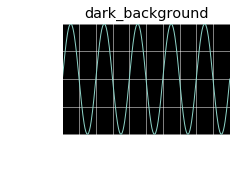

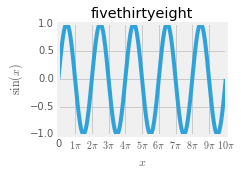

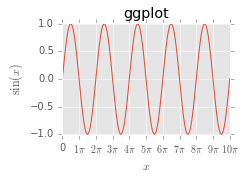

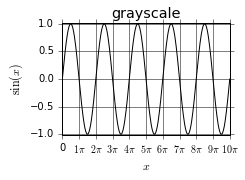

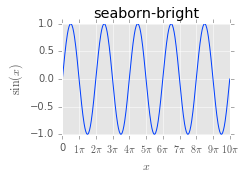

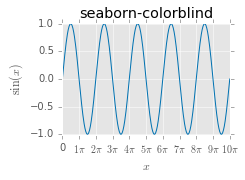

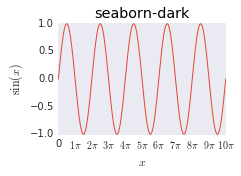

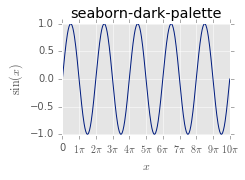

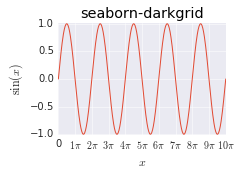

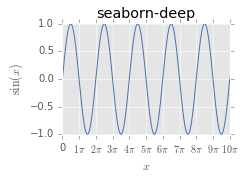

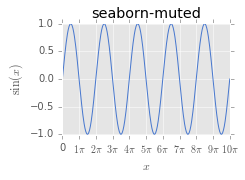

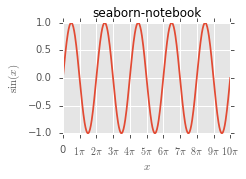

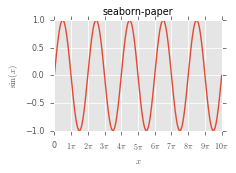

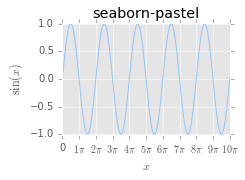

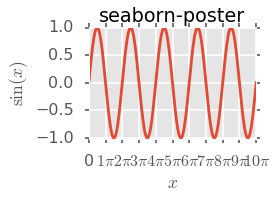

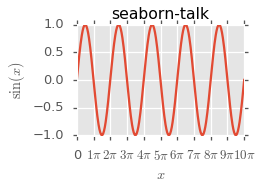

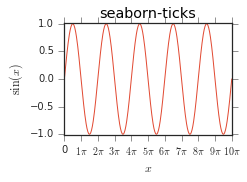

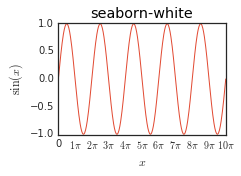

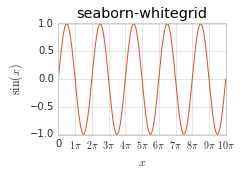

In [162]:
for style in sorted(plt.style.available):
    plt.figure(figsize=(3, 2))
    with plt.style.context(style):
        sinusoid_figure()
        
        # We force the title to be black so we can read it, even on a white background.
        plt.title(style, color='black')

My own preference is for ``"ggplot"``, so I'll turn it on now using ``plt.style.use``.

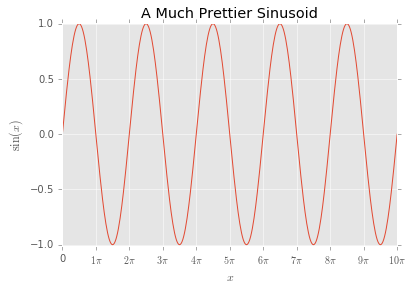

In [163]:
plt.style.use('ggplot')
sinusoid_figure()
plt.title("A Much Prettier Sinusoid")

Matplotlib offers a wide range of different plotting functions in addition to just ``plot``; here, we'll show just a few. Please visit [matplotlib.org](http://matplotlib.org) for much more complete documentation.

<Container object of 4 artists>

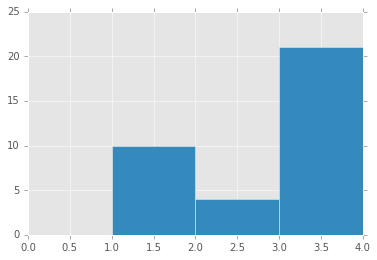

In [164]:
xs = np.array([0, 10, 4, 21])
plt.bar(np.arange(len(xs)), xs, width=1)

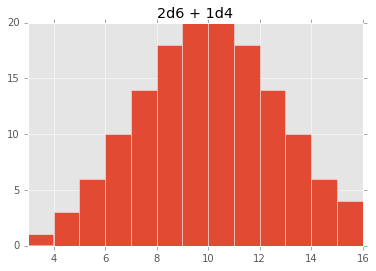

In [165]:
import itertools as it
die_rolls = list(map(np.sum, it.product(range(1, 7), range(1, 7), range(1, 5))))
plt.hist(die_rolls, bins=range(3, 6 + 6 + 4 + 1))
plt.xlim(xmin=3, xmax=16)
plt.title('2d6 + 1d4')

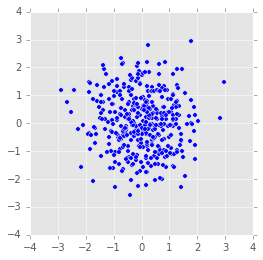

In [166]:
xs, ys = np.random.randn(2, 400)
plt.scatter(xs, ys)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
# Here, gca() stands for "get current axis."
plt.gca().set_aspect('equal')

- **TODO**: Seaborn for time series and joint plots.